In [1]:
import sys
sys.dont_write_bytecode=True

import os

import torch

from modules import VoxelDataset, LatentDataset
from modules import Diffusion
from modules import Encoder
from modules import Decoder
from modules import DiffusionTrainer
from modules import VanillaDiffusionSampler, KEulerDiffusionSampler
from modules import plot_part_by_voxel_coords, plot_objt_by_latents

from torch.utils.data import DataLoader
from torch.backends import cudnn

from tqdm import tqdm

cudnn.benchmark = True

device = 'cuda'

In [2]:
pram = {
    'data_dir_pth': './dataset/chair_voxel_data_remove_duplicate',
    'part_counts_npy_pth': './dataset/each_chair_parts_count_remove_duplicate.npy',
    'outlier_objt_indices_npy_pth': './dataset/outlier_objt_indices.npy',
    'latents_remove_duplicate_npy_pth': './dataset/latents_remove_duplicate.npy',
    'batch_size': 1,
    'voxel_map_shape': (128, 128, 128),
    'designate_num_objts': 1,
    'train_test_split_ratio_train': 1,
    'latent_dim': (64, 64),
    'beta_start': 1e-4,
    'beta_end': 2e-2,
    'training_steps': 1000,
    'inference_steps': 40,
    'warmup': 10
}

In [3]:
decoder = Decoder(pram['latent_dim'], vd_ch=8).to(device)

saved_ckpt = torch.load('./models/encoder_decoder_8.pt')

decoder.load_state_dict(saved_ckpt['decoder_state_dict'])

<All keys matched successfully>

In [4]:
train_dataset = LatentDataset(pram['latents_remove_duplicate_npy_pth'])

part_latent = torch.tensor(train_dataset[0], device=device)
part_latent = part_latent.view(1, *part_latent.shape)

In [5]:
# pred_part = torch.sigmoid(decoder(part_latent))
# (pred_part > 0.5).nonzero().shape

In [6]:
# voxel_coords = (pred_part > 0.5).nonzero()[:, 2:]

In [7]:
# plot_part_by_voxel_coords(voxel_coords)

In [8]:
diffusion = Diffusion().to(device)

saved_ckpt = torch.load('./models/diffusion_saved.pt')

diffusion.load_state_dict(saved_ckpt['diffusion_state_dict'])

<All keys matched successfully>

In [9]:
trainer = DiffusionTrainer(diffusion,
                           pram['beta_start'],
                           pram['beta_end'],
                           pram['training_steps']).to(device)

In [10]:
noised_part_latent = trainer.get_x_T(part_latent)

In [ ]:
# vanilla_sampler = VanillaDiffusionSampler(diffusion,
#                                           pram['beta_start'],
#                                           pram['beta_end'],
#                                           pram['training_steps']).to(device)

In [ ]:
# x_T = torch.randn((pram['batch_size'], 1, *pram['latent_dim']), device=device)
# x_T = pred_part

# x_t = x_T
# for time_step in tqdm(reversed(range(pram['training_steps']))):
#     x_t = vanilla_sampler(x_t, time_step)
# x_0 = x_t

In [11]:
euler_sampler = KEulerDiffusionSampler(diffusion,
                                       pram['beta_start'],
                                       pram['beta_end'],
                                       pram['inference_steps'],
                                       pram['training_steps']).to(device)

In [12]:
x_T = noised_part_latent
x_T = x_T * euler_sampler.initial_scale

for time_step in tqdm(range(pram['inference_steps'])):
    x_T = euler_sampler(x_T, time_step)
x_0 = x_T

100%|██████████| 40/40 [01:04<00:00,  1.61s/it]


In [13]:
pred_part = torch.sigmoid(decoder(x_0))

torch.max(pred_part)

tensor(0.7402, device='cuda:0', grad_fn=<MaxBackward1>)

In [16]:
(pred_part > 0.6).nonzero().shape

torch.Size([1054, 5])

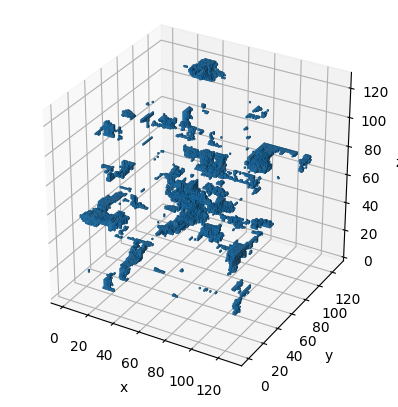

In [17]:
voxel_coords = (pred_part > 0.5).nonzero()[:, 2:]
plot_part_by_voxel_coords(voxel_coords)